In [3]:
# -*- coding: utf-8 -*-
from hyperparams import Hyperparams as hp
import os
import codecs
from jamo import h2j, j2hcj
from tqdm import tqdm
import tensorflow as tf
import numpy as np
import librosa
import matplotlib.pyplot as plt

In [4]:
trascript = hp.transcript_pos
lines = codecs.open(trascript, 'r', 'utf-8').readlines()

if not (os.path.isdir(hp.mels_dir)):
    os.mkdir(hp.mels_dir)
    print('{%s} does not exist, created {%s}'.format(hp.mels_dir, hp.mels_dir))
    
if not (os.path.isdir(hp.mags_dir)):
    os.mkdir(hp.mags_dir)
    print('{%s} does not exist, created {%s}'.format(hp.mags_dir, hp.mags_dir))

In [5]:
def load_vocab():
    char2idx = {char: idx for idx, char in enumerate(hp.vocab)}
    idx2char = {idx: char for idx, char in enumerate(hp.vocab)}
    return char2idx, idx2char

In [48]:
fnames, texts, secs, text_lengths = [], [], [], []
char2idx, idx2char = load_vocab();

for line in tqdm(lines):
    line = j2hcj(line)
    fname, _, text, sec = line.strip().split('|')
    encodedText = [char2idx[char] for char in text]
    encodedText = np.array(encodedText, np.int32).tostring()
    
    fnames.append(fname); 
    texts.append(encodedText)
    secs.append(float(sec)); 
    text_lengths.append(len(encodedText))
    
# fnames = np.asarray(fnames)
# texts = np.asarray(texts)
# secs = np.asarray(secs)

100%|██████████████████████████████████████████████████████████████████████████| 12853/12853 [00:01<00:00, 9126.88it/s]


In [49]:
text_lengths

[188,
 204,
 80,
 112,
 92,
 84,
 132,
 188,
 228,
 168,
 88,
 112,
 172,
 196,
 112,
 168,
 68,
 116,
 220,
 104,
 228,
 220,
 120,
 152,
 148,
 144,
 96,
 108,
 140,
 164,
 196,
 180,
 172,
 212,
 268,
 184,
 132,
 264,
 212,
 148,
 144,
 124,
 148,
 120,
 136,
 196,
 172,
 136,
 228,
 220,
 224,
 152,
 104,
 120,
 100,
 152,
 92,
 104,
 132,
 140,
 80,
 156,
 128,
 164,
 144,
 88,
 176,
 164,
 164,
 188,
 72,
 172,
 172,
 164,
 192,
 164,
 112,
 96,
 140,
 348,
 152,
 204,
 164,
 212,
 68,
 164,
 64,
 104,
 160,
 84,
 156,
 176,
 140,
 124,
 108,
 156,
 156,
 72,
 172,
 180,
 184,
 80,
 96,
 176,
 88,
 152,
 136,
 88,
 80,
 124,
 196,
 148,
 92,
 168,
 120,
 204,
 300,
 100,
 140,
 76,
 108,
 152,
 80,
 148,
 128,
 136,
 132,
 112,
 204,
 228,
 132,
 88,
 184,
 96,
 164,
 96,
 152,
 164,
 224,
 112,
 188,
 148,
 96,
 192,
 148,
 300,
 180,
 60,
 200,
 200,
 212,
 168,
 104,
 112,
 160,
 60,
 108,
 156,
 140,
 72,
 104,
 152,
 116,
 152,
 84,
 200,
 124,
 128,
 172,
 212,
 152,
 88,


In [50]:
fnames_tensor = tf.convert_to_tensor(fnames)
texts_tensor = tf.convert_to_tensor(texts)

In [51]:
num_epochs = 1
dataset = tf.data.Dataset.from_tensor_slices(tuple([fnames_tensor, texts_tensor])).shuffle(fnames_tensor.shape[0]).repeat(num_epochs)

In [52]:
iterator = dataset.make_one_shot_iterator()
file_name, text = iterator.get_next()
text_decoded = tf.decode_raw(text, tf.int32)

In [54]:
with tf.Session() as sess:    
    for i in range(3):
        f, t = sess.run([file_name, text_decoded])
        print(f)
        print(t)

b'4/4_4020.wav'
[ 8 40  4 24 14  1 25  0  9 40 14 20 10 24  4  8 25  7 24  0  8 33  8 26
  2 14 40  0  5 20  2  2 20  3 20  2 40  0  9 24  8  5 20  4  0  2 28  4
  4 20  8 34 55]
b'3/3_0112.wav'
[ 2 33  2  8 38  4  0  1 20  5  1 28  0  7 28  8 34  2  8 38  4  0  6 40
  4  8 24  0  6 29 52]
b'3/3_5024.wav'
[ 9 28  8 32  8 14 40]


In [5]:
#Random Selection
# randIdx = np.random.choice(range(len(lines)), 20)
# randIdx.sort()
# print(randIdx)

# fnames = fnames[randIdx]
# texts = texts[randIdx]
# secs = secs[randIdx]

[  307  1088  1267  1306  1905  2194  2735  3272  4068  4715  5728  6021
  6259 10028 10379 10402 11018 11542 12225 12584]


In [55]:
maxLen, minLen = max(text_lengths), min(text_lengths)

In [75]:
def spectrogram(wav, nsc, nov, fs):
    
    
    S = librosa.feature.melspectrogram(y=wav, sr=fs, n_fft=nsc, hop_length=nov, power=2.0)
    dbS = 20 * np.log10(np.maximum(S, hp.eps))
    
    
    return dbS

def mel_spectrogram(wav, nsc, nov, fs):
    
    
    S = librosa.feature.melspectrogram(y=wav, sr=fs, n_fft=nsc, hop_length=nov, power=2.0, n_mels = hp.n_mels)
    dbS = 20 * np.log10(np.maximum(S, hp.eps))
    
    
    return dbS

def true_spectrogram(wav, nsc, nov):
    
    
    S = librosa.core.stft(wav, n_fft=nsc, hop_length=nov)
    Sxx = abs(S)
    dbS = 20 * np.log10(np.maximum(Sxx, hp.eps))
    
    
    return dbS

In [104]:
def learning_rate_decay(init_lr, global_step, warmup_steps=4000.):
    '''Noam scheme from tensor2tensor'''
    step = tf.cast(global_step + 1, dtype=tf.float32)
    return init_lr * warmup_steps ** 0.5 * tf.minimum(step * warmup_steps ** -1.5, step ** -0.5)

In [58]:
fname = file_name
text = text_decoded

In [82]:
def spectrogram_wrap_up(fname):
    
    fname = fname.decode()
    npy_name = fname.split('/')[1].replace('wav', 'npy')
    mel_path = os.path.join(hp.mels_dir, npy_name)
    mag_path = os.path.join(hp.mags_dir, npy_name)
    
    #     if os.path.isfile(mel_path) and os.path.isfile(mag_path):
    if False:

        mag = np.load(mag_path)
        mel = np.load(mel_path) 

    else :

        fpath = os.path.join(hp.data_dir, fname)
        wav, fs = librosa.core.load(fpath, mono=True)
        nsc = np.int(fs * hp.nsc_sec)
        nov = np.int(fs * hp.nov_sec)
        mag_coef = np.mean(spectrogram(wav, nsc, nov, fs), axis=0)
        mel = mel_spectrogram(wav, nsc, nov, fs)
        mag = true_spectrogram(wav, nsc, nov)

        active = np.where(mag_coef > hp.db_limit)[0]

        first = active[0]
        last = active[-1] + 1

        if first - hp.offset >= 0:
            first = first - hp.offset
        else:
                first = 0

        if last + hp.offset < len(mag_coef):
            last = last + hp.offset
        else:
            last = len(mag_coef)

        mag = mag[:, first:last]
        mel = mel[:, first:last]

        mag = mag / hp.max_db
        mel = mel / hp.max_db

        # Do I really need 
        t = mel.shape[1]
        num_paddings = hp.r - (t % hp.r) if t % hp.r != 0 else 0 # 0 for multiples

        mel = np.pad(mel.T, [[0, num_paddings], [0, 0]], mode="minimum")
        mag = np.pad(mag.T, [[0, num_paddings], [0, 0]], mode="minimum")

        mel = mel.T
        mag = mag.T

        mel = mel.astype(np.float32)
        mag = mag.astype(np.float32) # Default is float64, type crashes at the Attention Wrapper

        print('{:d}:{:d}'.format(first, last))

        np.save(mag_path, mag)
        np.save(mel_path, mel)

#     print(fname)
#     plt.figure(figsize=(20, 4))
#     plt.subplot(1, 3, 1)
#     plt.imshow(mag, origin='lower')
#     plt.colorbar()
#     plt.subplot(1, 3, 2)
#     plt.imshow(mel, origin='lower')
#     plt.colorbar()
#     plt.subplot(1, 3, 3)
#     plt.plot(mag_coef)
#     plt.show()

    y = mel.T.reshape((-1, hp.n_mels*hp.r))
    mel = (mel.T[hp.r - 1::hp.r, :]) # Reduce sample size by r
    mag = mag.T
    
    return y, mel, mag

In [84]:
y, mel, mag = tf.py_func(spectrogram_wrap_up, [fname], [tf.float32, tf.float32, tf.float32])

In [80]:
with tf.Session() as sess:    
    for i in range(3):
        f = sess.run([fname])
        print(f[0].decode())

3/3_1338.wav
4/4_0327.wav
2/2_0937.wav


In [85]:
with tf.Session() as sess:    
    for i in range(3):
        y_, mel_, mag_ = sess.run([y, mel, mag])
        print(f)
        print(t)

15:71
[b'2/2_0937.wav']
[ 9 28  8 32  8 14 40]
14:59
[b'2/2_0937.wav']
[ 9 28  8 32  8 14 40]
18:64
[b'2/2_0937.wav']
[ 9 28  8 32  8 14 40]


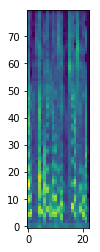

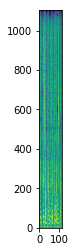

In [9]:
plt.imshow(mels[0].T, origin='lower')
plt.show()
plt.imshow(mags[0].T, origin='lower')
plt.show()

In [10]:
mels[0].shape

(23, 80)

In [11]:
decoder_inputs = []

for i in range(len(mels)):
    mel = mels[i]
    decoder_input = tf.concat((tf.zeros_like(mel[:1, :]), mel[:-1, :]), 0)
    decoder_inputs.append(decoder_input)

In [12]:
sess = tf.InteractiveSession()

In [13]:
sess.run(tf.global_variables_initializer())
x = sess.run(decoder_inputs)
x

[array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.21757236, -0.28472632, -0.4245518 , ..., -0.44723514,
         -0.4819315 , -0.6203897 ],
        [-0.427609  , -0.37618244, -0.62962365, ..., -0.7592621 ,
         -0.7180713 , -0.8184608 ],
        ...,
        [-0.20769385, -0.2505387 , -0.48971453, ..., -0.8058968 ,
         -0.7694844 , -0.8367346 ],
        [-0.3852577 , -0.3704304 , -0.5100678 , ..., -0.64140844,
         -0.7375024 , -0.8104269 ],
        [-0.4155981 , -0.34552255, -0.03717517, ..., -0.8435223 ,
         -0.8050407 , -0.9186932 ]], dtype=float32),
 array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  

In [14]:
with tf.variable_scope("embedding", reuse=tf.AUTO_REUSE):
    lookup_table = tf.get_variable('lookup_table', 
                                   dtype=tf.float32, 
                                   shape=[len(hp.vocab), hp.embed_size],
                                   initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.01))

In [15]:
sess.run(tf.global_variables_initializer())
sess.run(lookup_table)

array([[ 0.00781345,  0.00903901, -0.01204233, ...,  0.0053286 ,
         0.00185756, -0.00181932],
       [ 0.00604452,  0.01520777, -0.00356364, ...,  0.01096257,
        -0.01304835,  0.00776851],
       [-0.01549294, -0.01503795, -0.00045527, ..., -0.0089074 ,
        -0.01934168,  0.00554074],
       ...,
       [ 0.01318593, -0.0106275 , -0.0066824 , ...,  0.00046617,
        -0.00705075, -0.01077174],
       [ 0.01535135,  0.00963922,  0.00997594, ...,  0.01410264,
         0.00525331, -0.0073107 ],
       [ 0.00660072, -0.00017402,  0.00947494, ..., -0.01633317,
         0.00316355, -0.0038969 ]], dtype=float32)

In [16]:
embed_texts = []

for i in range(len(texts)):
    text = texts[i]
    embed_text = tf.nn.embedding_lookup(lookup_table, text)
    embed_text = tf.expand_dims(embed_text, 0)
    embed_texts.append(embed_text)

In [17]:
embed_text

<tf.Tensor 'ExpandDims_19:0' shape=(1, 31, 256) dtype=float32>

In [18]:
lookup_table.name

'embedding/lookup_table:0'

In [19]:
encodedText

array([ 8, 28,  4, 14, 21,  0,  8, 37,  8, 34,  4,  8, 38,  2,  0,  8, 37,
        2, 20,  2, 14, 40,  0, 18, 20,  4, 18, 20,  4, 14, 21,  8, 32, 52])

In [20]:
x = sess.run(embed_texts)

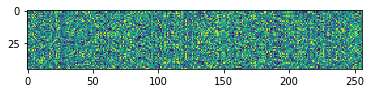

In [21]:
plt.imshow(x[5][0, :, :])

In [22]:
prenet_results = []

for i in tqdm(range(len(embed_texts))):
    embed_text = embed_texts[i]
    with tf.variable_scope("prenet", reuse=tf.AUTO_REUSE):
        outputs = tf.layers.dense(embed_text, units=hp.num_prenet_node_1, activation=tf.nn.relu, name="dense1")
        outputs = tf.layers.dropout(outputs, rate=hp.dropout_rate, name="dropout1")
        outputs = tf.layers.dense(outputs, units=hp.num_prenet_node_2, activation=tf.nn.relu, name="dense2")
        outputs = tf.layers.dropout(outputs, rate=hp.dropout_rate, name="dropout2") 
        
    prenet_results.append(outputs)
        

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 45.63it/s]


In [23]:
# sess.run(tf.global_variables_initializer())
# x = sess.run(prenet_results)

In [24]:
# for i in tqdm(range(len(embed_texts))):
conv_bank_results = []

for i in tqdm(range(len(prenet_results))):
    with tf.variable_scope("conv1d_banks", reuse=tf.AUTO_REUSE):
        prenet_result = prenet_results[i]

        for k in range(1, hp.K + 1):
            with tf.variable_scope("filter_num_{}".format(k)):
                params = {"inputs":prenet_result, "filters":hp.num_k_filter, "kernel_size":k,
                        "dilation_rate":1, "padding":"SAME", "activation":None, 
                        "use_bias":False, "reuse":tf.AUTO_REUSE}
                
                # Works when resue = True
                # For i loop, filter is reused.

                conv_outputs = tf.layers.conv1d(**params)
                if k == 1:
                    conv_bank_outputs = conv_outputs
                else:
                    conv_bank_outputs = tf.concat((conv_bank_outputs, conv_outputs), axis=2)
                
    conv_bank_results.append(conv_bank_outputs)
                
#     print(prenet_outputs)


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.98it/s]


In [25]:
sess.run(tf.global_variables_initializer())
sess.run(conv_bank_results)

[array([[[ 0.00420818, -0.00079943,  0.00518581, ..., -0.00401495,
          -0.00426698, -0.00580667],
         [ 0.00155715, -0.00034018,  0.0118791 , ..., -0.0023792 ,
          -0.00589197,  0.00230513],
         [ 0.01353355,  0.00267546,  0.00789661, ...,  0.00235338,
          -0.00219121, -0.00011556],
         ...,
         [-0.00017588, -0.00244695, -0.00076187, ..., -0.0017112 ,
           0.00262147,  0.00665932],
         [ 0.00162065, -0.00275765,  0.01089821, ..., -0.00230578,
           0.00187523,  0.00411452],
         [ 0.00580463,  0.00267164, -0.00119835, ..., -0.00337061,
           0.00292206, -0.00078727]]], dtype=float32),
 array([[[-0.00017588, -0.00244695, -0.00076187, ...,  0.00508384,
          -0.00768825, -0.00020034],
         [ 0.00162065, -0.00275765,  0.01089821, ...,  0.00248378,
          -0.00322946, -0.00138223],
         [ 0.00476269,  0.00238548,  0.007925  , ...,  0.00336148,
          -0.00031316, -0.00027118],
         ...,
         [ 0.00476

In [26]:
max_pooling_results = [];

for i in tqdm(range(len(conv_bank_results))):
    conv_bank_result = conv_bank_results[i]

    max_pooled = tf.layers.max_pooling1d(conv_bank_result, pool_size=2, strides=1, padding="same")
                
    max_pooling_results.append(max_pooled)
    

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 455.78it/s]


In [27]:
sess.run(tf.global_variables_initializer())
x = sess.run(max_pooling_results)

In [28]:
x[0].shape
conv_bank_results[0].shape

TensorShape([Dimension(1), Dimension(78), Dimension(2048)])

In [29]:
conv_proj_1_results = []

with tf.variable_scope("conv1d_1"):
    for i in tqdm(range(len(max_pooling_results))):
        max_pooling_result = max_pooling_results[i]
        
        params = {"inputs":max_pooling_result, "filters":hp.num_conv1d_proj_filter, "kernel_size":hp.size_conv1d_proj_filter,
                        "dilation_rate":1, "padding":"SAME", "activation":None, 
                        "use_bias":False, "reuse":tf.AUTO_REUSE}

        conv_proj_1_result = tf.layers.conv1d(**params)

        conv_proj_1_results.append(conv_proj_1_result)

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 211.09it/s]


In [30]:
sess.run(tf.global_variables_initializer())
x = sess.run(conv_proj_1_results)

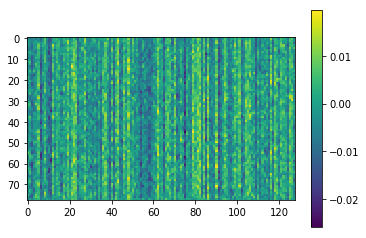

In [31]:
plt.imshow(x[0][0, :, :])
plt.colorbar()
# plt.clim([-0.4, 0.4])

In [32]:
batch_norm_1_results = []

with tf.variable_scope("conv1d_1"):
    for i in tqdm(range(len(conv_proj_1_results))):
        conv_proj_1_result = conv_proj_1_results[i]

        bn_1_result = tf.contrib.layers.batch_norm(inputs=conv_proj_1_result,
                                               center=True,
                                               scale=True,
                                               updates_collections=None,
                                               is_training=True,
                                               scope="conv1d_1",
                                               fused=True,
                                               reuse=tf.AUTO_REUSE)
        bn_1_act = tf.nn.relu(bn_1_result)
        
        batch_norm_1_results.append(bn_1_act)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.40it/s]


In [33]:
sess.run(tf.global_variables_initializer())
x = sess.run(batch_norm_1_results)

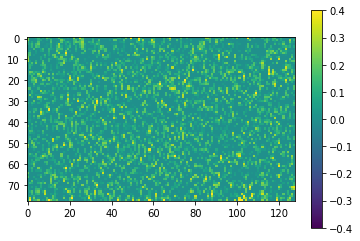

In [34]:
plt.imshow(x[0][0, :, :])
plt.colorbar()
plt.clim([-0.4, 0.4])

In [35]:
conv_proj_2_results = []

with tf.variable_scope("conv1d_2"):
    for i in tqdm(range(len(batch_norm_1_results))):
        batch_norm_1_result = batch_norm_1_results[i]
        
        params = {"inputs":batch_norm_1_result, "filters":hp.num_conv1d_proj_filter, "kernel_size":hp.size_conv1d_proj_filter,
                        "dilation_rate":1, "padding":"SAME", "activation":None, 
                        "use_bias":False, "reuse":tf.AUTO_REUSE}

        conv_proj_2_result = tf.layers.conv1d(**params)

        conv_proj_2_results.append(conv_proj_2_result)

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 121.54it/s]


In [36]:
sess.run(tf.global_variables_initializer())
x = sess.run(conv_proj_2_results)

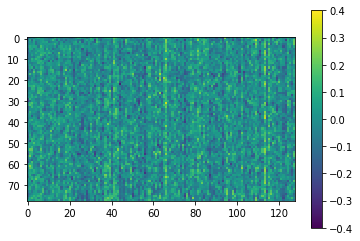

In [37]:
plt.imshow(x[0][0, :, :])
plt.colorbar()
plt.clim([-0.4, 0.4])

In [38]:
batch_norm_2_results = []

with tf.variable_scope("conv1d_2"):
    for i in tqdm(range(len(conv_proj_2_results))):
        conv_proj_2_result = conv_proj_2_results[i]

        bn_2_result = tf.contrib.layers.batch_norm(inputs=conv_proj_2_result,
                                               center=True,
                                               scale=True,
                                               updates_collections=None,
                                               is_training=True,
                                               scope="conv1d_2",
                                               fused=True,
                                               reuse=tf.AUTO_REUSE)
        bn_2_act = tf.nn.relu(bn_2_result)
        
        batch_norm_2_results.append(bn_2_act)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 69.63it/s]


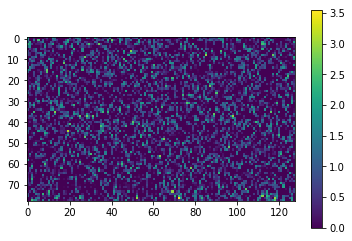

In [39]:
sess.run(tf.global_variables_initializer())
x = sess.run(batch_norm_2_results)

plt.imshow(x[0][0, :, :])
plt.colorbar()

In [40]:
batch_norm_2_results

[<tf.Tensor 'conv1d_2_1/Relu:0' shape=(1, 78, 128) dtype=float32>,
 <tf.Tensor 'conv1d_2_1/Relu_1:0' shape=(1, 34, 128) dtype=float32>,
 <tf.Tensor 'conv1d_2_1/Relu_2:0' shape=(1, 31, 128) dtype=float32>,
 <tf.Tensor 'conv1d_2_1/Relu_3:0' shape=(1, 32, 128) dtype=float32>,
 <tf.Tensor 'conv1d_2_1/Relu_4:0' shape=(1, 65, 128) dtype=float32>,
 <tf.Tensor 'conv1d_2_1/Relu_5:0' shape=(1, 45, 128) dtype=float32>,
 <tf.Tensor 'conv1d_2_1/Relu_6:0' shape=(1, 34, 128) dtype=float32>,
 <tf.Tensor 'conv1d_2_1/Relu_7:0' shape=(1, 46, 128) dtype=float32>,
 <tf.Tensor 'conv1d_2_1/Relu_8:0' shape=(1, 68, 128) dtype=float32>,
 <tf.Tensor 'conv1d_2_1/Relu_9:0' shape=(1, 34, 128) dtype=float32>,
 <tf.Tensor 'conv1d_2_1/Relu_10:0' shape=(1, 42, 128) dtype=float32>,
 <tf.Tensor 'conv1d_2_1/Relu_11:0' shape=(1, 27, 128) dtype=float32>,
 <tf.Tensor 'conv1d_2_1/Relu_12:0' shape=(1, 38, 128) dtype=float32>,
 <tf.Tensor 'conv1d_2_1/Relu_13:0' shape=(1, 20, 128) dtype=float32>,
 <tf.Tensor 'conv1d_2_1/Relu_14:

In [41]:
from operator import add
res_outputs = list(map(add, prenet_results, batch_norm_2_results))

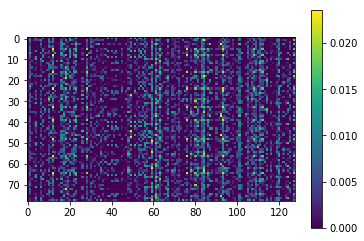

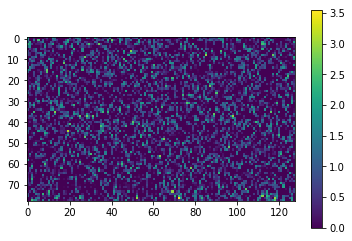

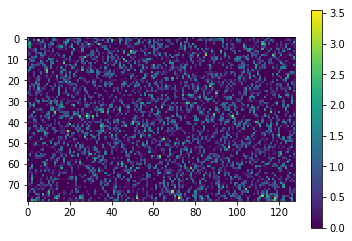

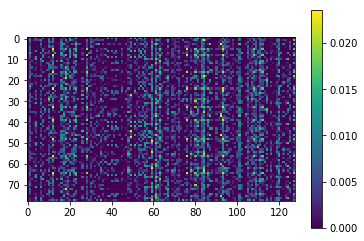

In [42]:
plt.imshow(sess.run(prenet_results[0][0, :, :]))
plt.colorbar()
plt.show()

plt.imshow(sess.run(batch_norm_2_results[0][0, :, :]))
plt.colorbar()
plt.show()

plt.imshow(sess.run(res_outputs[0][0, :, :]))
plt.colorbar()
plt.show()

plt.imshow(sess.run(res_outputs[0][0, :, :] - batch_norm_2_results[0][0, :, :]))
plt.colorbar()
plt.show()

In [43]:
for i in range(hp.num_highwaynet_blocks):
    scope = "highwaynet_{:d}".format(i)
    with tf.variable_scope(scope):
        
        if i == 0:
            highwaynet_inputs = res_outputs
        else:
            highwaynet_inputs = highwaynet_outputs
        
        highwaynet_outputs = []
            
        for j in range(len(highwaynet_inputs)):
            highwaynet_input = highwaynet_inputs[j]
            
            H = tf.layers.dense(highwaynet_input, units=hp.num_highwaynet_units, activation=tf.nn.relu, name="dense1", reuse=tf.AUTO_REUSE)
            T = tf.layers.dense(highwaynet_input, units=hp.num_highwaynet_units, activation=tf.nn.sigmoid,
                                bias_initializer=tf.constant_initializer(-1.0), name="dense2", reuse=tf.AUTO_REUSE)
            highwaynet_output = H*T + highwaynet_input*(1.-T)
            
            highwaynet_outputs.append(highwaynet_output)
            
    

In [44]:
sess.run(tf.global_variables_initializer())
x = sess.run(highwaynet_outputs)

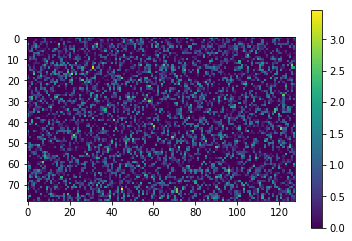

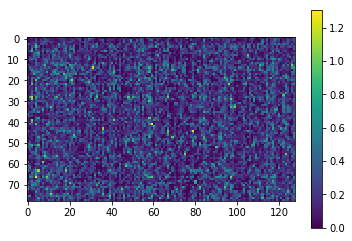

In [45]:
plt.imshow(sess.run(res_outputs[0][0, :, :]))
plt.colorbar()
plt.show()

plt.imshow(x[0][0, :, :])
plt.colorbar()
plt.show()

In [46]:
gru_results = []
with tf.variable_scope("gru", reuse=tf.AUTO_REUSE):
    for i in range(len(highwaynet_outputs)):
#     cell = tf.contrib.rnn.GRUCell(hp.num_gru_units)
#     cell_bw = tf.contrib.rnn.GRUCell(hp.num_gru_units)
        cell = tf.contrib.rnn.GRUCell(128)
        cell_bw = tf.contrib.rnn.GRUCell(128)

        highwaynet_output = highwaynet_outputs[i]
        
        output, _ = tf.nn.bidirectional_dynamic_rnn(cell, cell_bw, highwaynet_output, dtype=tf.float32)
        output = tf.concat(output, 2)
        
        gru_results.append(output)
    

In [47]:
sess.run(tf.global_variables_initializer())
x = sess.run(gru_results)

In [48]:
decoder_prenet_results = []

for i in tqdm(range(len(decoder_inputs))):
    decoder_input = decoder_inputs[i]
    with tf.variable_scope("decoder_prenet", reuse=tf.AUTO_REUSE):
        outputs = tf.layers.dense(decoder_input, units=hp.num_prenet_node_1, activation=tf.nn.relu, name="dense1")
        outputs = tf.layers.dropout(outputs, rate=hp.dropout_rate, name="dropout1")
        outputs = tf.layers.dense(outputs, units=hp.num_prenet_node_2, activation=tf.nn.relu, name="dense2")
        outputs = tf.layers.dropout(outputs, rate=hp.dropout_rate, name="dropout2") 
        
    decoder_prenet_results.append(outputs)

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 109.57it/s]


In [49]:
sess.run(tf.global_variables_initializer())
x = sess.run(decoder_prenet_results)

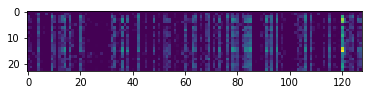

In [50]:
plt.imshow(x[0])

In [51]:
decs, states = [], []

with tf.variable_scope("attention_decoder", reuse=tf.AUTO_REUSE):
    
    for i in range(len(gru_results)):
        gru_result = gru_results[i]
        decoder_prenet_result = tf.expand_dims(decoder_prenet_results[i], 0)
        
        attention_mechanism = tf.contrib.seq2seq.BahdanauAttention(hp.num_attention_units, gru_result)
        decoder_cell = tf.contrib.rnn.GRUCell(hp.num_gru_units)
        cell_with_attention = tf.contrib.seq2seq.AttentionWrapper(decoder_cell,
                                                                  attention_mechanism,
                                                                  hp.num_attention_units,
                                                                  alignment_history=True)
        dec, state = tf.nn.dynamic_rnn(cell_with_attention, decoder_prenet_result, dtype=tf.float32)
        
        decs.append(dec)
        states.append(state)


In [52]:
# sess.run(states)
# Error occurs if you tries to run states 

In [53]:
y_hats, alignments = [], []
    
with tf.variable_scope("attention_decoder", reuse=tf.AUTO_REUSE):
    
    for i in range(len(states)):
        state = states[i]
        dec = decs[i]

        alignment = tf.transpose(state.alignment_history.stack(),[1,2,0])
        
        with tf.variable_scope("decoder_gru_1", reuse=tf.AUTO_REUSE):
            cell = tf.contrib.rnn.GRUCell(128)
            output, _ = tf.nn.dynamic_rnn(cell, dec, dtype=tf.float32)
            gru_output_1 = tf.concat(output, 2)
            
        dec = dec + gru_output_1

        with tf.variable_scope("decoder_gru_2", reuse=tf.AUTO_REUSE):
            cell = tf.contrib.rnn.GRUCell(128)
            output, _ = tf.nn.dynamic_rnn(cell, dec, dtype=tf.float32)
            gru_output_2 = tf.concat(output, 2)
            
        dec = dec + gru_output_2

        # Outputs => (N, T_y/r, n_mels*r)
        y_hat = tf.layers.dense(dec, hp.n_mels*hp.r)
        
        y_hats.append(y_hat)
        alignments.append(alignment)

In [54]:
sess.run(tf.global_variables_initializer())
x = sess.run(y_hats)

In [55]:
yy = sess.run(alignments)
y_hat = y_hats[i]
dec_2_reshape = tf.reshape(y_hat, [1, -1, hp.n_mels])

In [56]:
sess.run(tf.global_variables_initializer())
x = sess.run(dec_2_reshape)

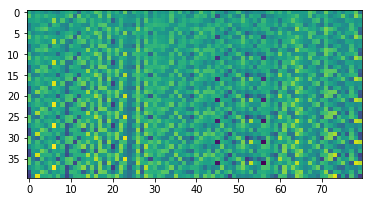

In [57]:
plt.imshow(x[0])

In [58]:
dec_2_inputs = []

with tf.variable_scope("decoder2", reuse=tf.AUTO_REUSE):
    for i in range(len(y_hats)):
        y_hat = y_hats[i]
        dec_2_input = tf.reshape(y_hat, [1, -1, hp.n_mels])
        
        dec_2_inputs.append(dec_2_input)

In [59]:
dec_2_conv_bank_results = []

with tf.variable_scope("decoder2", reuse=tf.AUTO_REUSE):
    for i in tqdm(range(len(dec_2_inputs))):
        with tf.variable_scope("conv1d_banks", reuse=tf.AUTO_REUSE):
            dec_2_input = dec_2_inputs[i]

            for k in range(1, hp.K + 1):
                with tf.variable_scope("filter_num_{}".format(k)):
                    params = {"inputs":dec_2_input, "filters":hp.num_k_filter, "kernel_size":k,
                            "dilation_rate":1, "padding":"SAME", "activation":None, 
                            "use_bias":False, "reuse":tf.AUTO_REUSE}

                    # Works when resue = True
                    # For i loop, filter is reused.

                    conv_outputs = tf.layers.conv1d(**params)
                    if k == 1:
                        conv_bank_outputs = conv_outputs
                    else:
                        conv_bank_outputs = tf.concat((conv_bank_outputs, conv_outputs), axis=2)

        dec_2_conv_bank_results.append(conv_bank_outputs)


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.06it/s]


In [60]:
sess.run(tf.global_variables_initializer())
x = sess.run(dec_2_conv_bank_results)

In [61]:
x[0].shape

(1, 115, 2048)

In [62]:
dec_2_max_pooling_results = []

with tf.variable_scope("decoder2", reuse=tf.AUTO_REUSE):
    for i in tqdm(range(len(dec_2_inputs))):
        dec_2_conv_bank_result = dec_2_conv_bank_results[i]

        max_pooled = tf.layers.max_pooling1d(dec_2_conv_bank_result, pool_size=2, strides=1, padding="same")

        dec_2_max_pooling_results.append(max_pooled)

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 371.36it/s]


In [63]:
dec_2_conv_proj_1_results = []

with tf.variable_scope("decoder2", reuse=tf.AUTO_REUSE):
    with tf.variable_scope("conv1d_1"):
        for i in tqdm(range(len(dec_2_max_pooling_results))):
            dec_2_max_pooling_result = dec_2_max_pooling_results[i]

            params = {"inputs":dec_2_max_pooling_result, "filters":hp.num_conv1d_proj_filter, "kernel_size":hp.size_conv1d_proj_filter,
                            "dilation_rate":1, "padding":"SAME", "activation":None, 
                            "use_bias":False, "reuse":tf.AUTO_REUSE}

            dec_2_conv_proj_1_result = tf.layers.conv1d(**params)

            dec_2_conv_proj_1_results.append(dec_2_conv_proj_1_result)

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 190.99it/s]


In [64]:
dec_2_batch_norm_1_results = []

with tf.variable_scope("decoder2", reuse=tf.AUTO_REUSE):
    with tf.variable_scope("conv1d_1"):
        for i in tqdm(range(len(dec_2_conv_proj_1_results))):
            dec_2_conv_proj_1_result = dec_2_conv_proj_1_results[i]

            bn_1_result = tf.contrib.layers.batch_norm(inputs=dec_2_conv_proj_1_result,
                                                   center=True,
                                                   scale=True,
                                                   updates_collections=None,
                                                   is_training=True,
                                                   scope="conv1d_1",
                                                   fused=True,
                                                   reuse=tf.AUTO_REUSE)
            bn_1_act = tf.nn.relu(bn_1_result)

            dec_2_batch_norm_1_results.append(bn_1_act)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 51.16it/s]


In [65]:
dec_2_conv_proj_2_results = []

with tf.variable_scope("decoder2", reuse=tf.AUTO_REUSE):
    with tf.variable_scope("conv1d_2"):
        for i in tqdm(range(len(dec_2_batch_norm_1_results))):
            dec_2_batch_norm_1_result = dec_2_batch_norm_1_results[i]

            params = {"inputs":dec_2_batch_norm_1_result, "filters":hp.num_conv1d_proj_filter, "kernel_size":hp.size_conv1d_proj_filter,
                            "dilation_rate":1, "padding":"SAME", "activation":None, 
                            "use_bias":False, "reuse":tf.AUTO_REUSE}

            dec_2_conv_proj_2_result = tf.layers.conv1d(**params)

            dec_2_conv_proj_2_results.append(dec_2_conv_proj_2_result)

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 157.90it/s]


In [66]:
dec_2_batch_norm_2_results = []

with tf.variable_scope("decoder2", reuse=tf.AUTO_REUSE):
    with tf.variable_scope("conv1d_2"):
        for i in tqdm(range(len(dec_2_conv_proj_2_results))):
            dec_2_conv_proj_2_result = dec_2_conv_proj_2_results[i]

            bn_2_result = tf.contrib.layers.batch_norm(inputs=dec_2_conv_proj_2_result,
                                                   center=True,
                                                   scale=True,
                                                   updates_collections=None,
                                                   is_training=True,
                                                   scope="conv1d_2",
                                                   fused=True,
                                                   reuse=tf.AUTO_REUSE)
            bn_2_act = tf.nn.relu(bn_2_result)
            dec_2_batch_norm_2_results.append(bn_2_act)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 58.38it/s]


In [67]:
dec_2_sync_results = []

with tf.variable_scope("decoder2", reuse=tf.AUTO_REUSE):
        for i in tqdm(range(len(dec_2_batch_norm_2_results))):
            dec_2_batch_norm_2_result = dec_2_batch_norm_2_results[i]

            dec_2_sync_result = tf.layers.dense(dec_2_batch_norm_2_result, 128)
            dec_2_sync_results.append(dec_2_sync_result)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 59.49it/s]


In [68]:
with tf.variable_scope("decoder2", reuse=tf.AUTO_REUSE):
    for i in range(hp.num_highwaynet_blocks):
        scope = "highwaynet_{:d}".format(i)
        with tf.variable_scope(scope):

            if i == 0:
                highwaynet_inputs = dec_2_sync_results
            else:
                highwaynet_inputs = highwaynet_outputs

            highwaynet_outputs = []

            for j in range(len(highwaynet_inputs)):
                highwaynet_input = highwaynet_inputs[j]

                H = tf.layers.dense(highwaynet_input, units=hp.num_highwaynet_units, activation=tf.nn.relu, name="dense1", reuse=tf.AUTO_REUSE)
                T = tf.layers.dense(highwaynet_input, units=hp.num_highwaynet_units, activation=tf.nn.sigmoid,
                                    bias_initializer=tf.constant_initializer(-1.0), name="dense2", reuse=tf.AUTO_REUSE)
                highwaynet_output = H*T + highwaynet_input*(1.-T)

                highwaynet_outputs.append(highwaynet_output)

In [69]:
dec_2_gru_results = []
with tf.variable_scope("gru", reuse=tf.AUTO_REUSE):
    for i in range(len(highwaynet_outputs)):
        cell = tf.contrib.rnn.GRUCell(128)
        cell_bw = tf.contrib.rnn.GRUCell(128)

        highwaynet_output = highwaynet_outputs[i]
        
        output, _ = tf.nn.bidirectional_dynamic_rnn(cell, cell_bw, highwaynet_output, dtype=tf.float32)
        output = tf.concat(output, 2)
        
        dec_2_gru_results.append(output)

In [70]:
z_hats = []

with tf.variable_scope("decoder2", reuse=tf.AUTO_REUSE):
    with tf.variable_scope("final", reuse=tf.AUTO_REUSE):
        for i in tqdm(range(len(dec_2_gru_results))):
            dec_2_gru_result = dec_2_gru_results[i]

            dec_2_result = tf.layers.dense(dec_2_gru_result, 1 + hp.nsc_sec*fs//2)
            z_hats.append(dec_2_result)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 59.51it/s]


In [71]:
z_hats

[<tf.Tensor 'decoder2_9/final/dense/BiasAdd:0' shape=(1, 115, 1103) dtype=float32>,
 <tf.Tensor 'decoder2_9/final/dense_1/BiasAdd:0' shape=(1, 45, 1103) dtype=float32>,
 <tf.Tensor 'decoder2_9/final/dense_2/BiasAdd:0' shape=(1, 50, 1103) dtype=float32>,
 <tf.Tensor 'decoder2_9/final/dense_3/BiasAdd:0' shape=(1, 50, 1103) dtype=float32>,
 <tf.Tensor 'decoder2_9/final/dense_4/BiasAdd:0' shape=(1, 85, 1103) dtype=float32>,
 <tf.Tensor 'decoder2_9/final/dense_5/BiasAdd:0' shape=(1, 70, 1103) dtype=float32>,
 <tf.Tensor 'decoder2_9/final/dense_6/BiasAdd:0' shape=(1, 55, 1103) dtype=float32>,
 <tf.Tensor 'decoder2_9/final/dense_7/BiasAdd:0' shape=(1, 60, 1103) dtype=float32>,
 <tf.Tensor 'decoder2_9/final/dense_8/BiasAdd:0' shape=(1, 95, 1103) dtype=float32>,
 <tf.Tensor 'decoder2_9/final/dense_9/BiasAdd:0' shape=(1, 45, 1103) dtype=float32>,
 <tf.Tensor 'decoder2_9/final/dense_10/BiasAdd:0' shape=(1, 55, 1103) dtype=float32>,
 <tf.Tensor 'decoder2_9/final/dense_11/BiasAdd:0' shape=(1, 40, 1

In [75]:
mags[0].shape

(115, 1103)

In [74]:
z_hats[0].shape

TensorShape([Dimension(1), Dimension(115), Dimension(1103)])

In [77]:
y_hats[0].shape

TensorShape([Dimension(1), Dimension(23), Dimension(400)])

In [78]:
ys[0].shape

(23, 400)

In [86]:
delta_y = lambda y_hat, y: y_hat - y, y_hats, ys

In [99]:
delta_ys = []

for i in range(len(y_hats)):
    delta_y = abs(y_hats[i][0, :, :] - ys[i])
    delta_ys.append(tf.reduce_mean(delta_y))
    
delta_zs = []

for i in range(len(z_hats)):
    delta_z = abs(z_hats[i][0, :, :] - mags[i])
    delta_zs.append(tf.reduce_mean(delta_z))

In [102]:
delta_ys

[<tf.Tensor 'Mean:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean_1:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean_2:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean_3:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean_4:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean_5:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean_6:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean_7:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean_8:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean_9:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean_10:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean_11:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean_12:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean_13:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean_14:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean_15:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean_16:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean_17:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean_18:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean_19:0' shape=() dtype=float32>]

In [103]:
loss1 = tf.reduce_mean(delta_ys)
loss2 = tf.reduce_mean(delta_zs)
loss = loss1 + loss2

In [106]:
hp.lr = 0.001

In [108]:
global_step = tf.Variable(0, name='global_step', trainable=False)
lr = learning_rate_decay(hp.lr, global_step=global_step)
optimizer = tf.train.AdamOptimizer(learning_rate=hp.lr)

## gradient clipping
gvs = optimizer.compute_gradients(loss)
clipped = []

for grad, var in gvs:
    grad = tf.clip_by_norm(grad, 5.)
    clipped.append((grad, var))
    
train_op = optimizer.apply_gradients(clipped, global_step=global_step)

In [111]:
sess.run(tf.global_variables_initializer())
sess.run([train_op, global_step])

[None, 1]